# models for opcode frequency

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2025-07-12 00:36:50.516838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Const

In [3]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data/processed')
MODEL_PATH = os.path.join(PATH, 'models')

In [4]:
with open(os.path.join(DATA_PATH, 'feature-opcode-freq_list.json')) as f:
    feature_list = json.load(f)

with open(os.path.join(DATA_PATH, 'labels-opcode-freq.json')) as f:
    labels = json.load(f)

In [5]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train-opcode-freq.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test-opcode-freq.csv'))

X_train = train_df[feature_list]
y_train = train_df[labels]

X_test = test_df[feature_list]
y_test = test_df[labels]

## CNN

### Structure

In [6]:
opcode_dim = len(feature_list)

def MLClassifier():
    return Sequential([
        Dense(512, input_dim=opcode_dim, kernel_regularizer=regularizers.L1L2(1e-6)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.L1L2(1e-6)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.L1L2(1e-6)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

model = MLClassifier()
model.compile(
    loss='binary_crossentropy',  # important for multi-label!
    optimizer=Adam(learning_rate=1e-6),
    metrics=['accuracy', 'AUC']
)


### Training

In [8]:
model_file = os.path.join(MODEL_PATH, "cnn_best_model_on_crpwarner_opcode_freq.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - AUC: 0.5582 - accuracy: 0.4219 - loss: 0.6913

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - AUC: 0.5868 - accuracy: 0.4170 - loss: 0.6670 - val_AUC: 0.3414 - val_accuracy: 0.5000 - val_loss: 0.9337 - learning_rate: 1.0000e-06
Epoch 2/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.6166 - accuracy: 0.4688 - loss: 0.6408

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - AUC: 0.6237 - accuracy: 0.4492 - loss: 0.6382 - val_AUC: 0.3472 - val_accuracy: 0.5000 - val_loss: 0.9279 - learning_rate: 1.0000e-06
Epoch 3/100
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.5996 - accuracy: 0.3828 - loss: 0.6675

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - AUC: 0.5825 - accuracy: 0.3885 - loss: 0.6835 - val_AUC: 0.3530 - val_accuracy: 0.5000 - val_loss: 0.9230 - learning_rate: 1.0000e-06
Epoch 4/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.6257 - accuracy: 0.4531 - loss: 0.6533

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.5967 - accuracy: 0.4358 - loss: 0.6785 - val_AUC: 0.3588 - val_accuracy: 0.5000 - val_loss: 0.9174 - learning_rate: 1.0000e-06
Epoch 5/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.6013 - accuracy: 0.4219 - loss: 0.6803

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.5957 - accuracy: 0.4246 - loss: 0.6723 - val_AUC: 0.3611 - val_accuracy: 0.5000 - val_loss: 0.9131 - learning_rate: 1.0000e-06
Epoch 6/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.5503 - accuracy: 0.3594 - loss: 0.7005

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.5696 - accuracy: 0.3865 - loss: 0.6993 - val_AUC: 0.3623 - val_accuracy: 0.5000 - val_loss: 0.9096 - learning_rate: 1.0000e-06
Epoch 7/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.6463 - accuracy: 0.4375 - loss: 0.6164

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.6093 - accuracy: 0.4397 - loss: 0.6571 - val_AUC: 0.3669 - val_accuracy: 0.5000 - val_loss: 0.9072 - learning_rate: 1.0000e-06
Epoch 8/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.6184 - accuracy: 0.4219 - loss: 0.6539

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - AUC: 0.5905 - accuracy: 0.3929 - loss: 0.6687 - val_AUC: 0.3715 - val_accuracy: 0.5000 - val_loss: 0.9036 - learning_rate: 1.0000e-06
Epoch 9/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.6659 - accuracy: 0.5000 - loss: 0.6056

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUC: 0.6372 - accuracy: 0.4665 - loss: 0.6321 - val_AUC: 0.3796 - val_accuracy: 0.5714 - val_loss: 0.9004 - learning_rate: 1.0000e-06
Epoch 10/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.5604 - accuracy: 0.3750 - loss: 0.6865

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - AUC: 0.5653 - accuracy: 0.3868 - loss: 0.6874 - val_AUC: 0.3831 - val_accuracy: 0.5714 - val_loss: 0.8972 - learning_rate: 1.0000e-06
Epoch 11/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.6424 - accuracy: 0.4844 - loss: 0.6296

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.6169 - accuracy: 0.4719 - loss: 0.6515 - val_AUC: 0.3819 - val_accuracy: 0.5714 - val_loss: 0.8946 - learning_rate: 1.0000e-06
Epoch 12/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.5939 - accuracy: 0.4062 - loss: 0.6654

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.5833 - accuracy: 0.4319 - loss: 0.6735 - val_AUC: 0.3843 - val_accuracy: 0.5714 - val_loss: 0.8928 - learning_rate: 1.0000e-06
Epoch 13/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.6174 - accuracy: 0.3906 - loss: 0.6453

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5994 - accuracy: 0.4019 - loss: 0.6611 - val_AUC: 0.3889 - val_accuracy: 0.5714 - val_loss: 0.8901 - learning_rate: 1.0000e-06
Epoch 14/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.5895 - accuracy: 0.4844 - loss: 0.6704

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.5922 - accuracy: 0.4738 - loss: 0.6746 - val_AUC: 0.3935 - val_accuracy: 0.5714 - val_loss: 0.8861 - learning_rate: 1.0000e-06
Epoch 15/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.5584 - accuracy: 0.4375 - loss: 0.6934

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - AUC: 0.5608 - accuracy: 0.4472 - loss: 0.7041 - val_AUC: 0.3981 - val_accuracy: 0.5714 - val_loss: 0.8845 - learning_rate: 1.0000e-06
Epoch 16/100
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5528 - accuracy: 0.4219 - loss: 0.7042

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - AUC: 0.5524 - accuracy: 0.4117 - loss: 0.7053 - val_AUC: 0.3981 - val_accuracy: 0.5714 - val_loss: 0.8838 - learning_rate: 1.0000e-06
Epoch 17/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - AUC: 0.5567 - accuracy: 0.4375 - loss: 0.7065

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.5760 - accuracy: 0.4394 - loss: 0.6860 - val_AUC: 0.4016 - val_accuracy: 0.6429 - val_loss: 0.8823 - learning_rate: 1.0000e-06
Epoch 18/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.5841 - accuracy: 0.3906 - loss: 0.6937

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.5824 - accuracy: 0.3907 - loss: 0.6922 - val_AUC: 0.4016 - val_accuracy: 0.6429 - val_loss: 0.8805 - learning_rate: 1.0000e-06
Epoch 19/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.6311 - accuracy: 0.5156 - loss: 0.6280

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - AUC: 0.6228 - accuracy: 0.4853 - loss: 0.6474 - val_AUC: 0.4074 - val_accuracy: 0.6429 - val_loss: 0.8758 - learning_rate: 1.0000e-06
Epoch 20/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.4944 - accuracy: 0.3125 - loss: 0.7597

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.5297 - accuracy: 0.3600 - loss: 0.7231 - val_AUC: 0.4155 - val_accuracy: 0.7143 - val_loss: 0.8731 - learning_rate: 1.0000e-06
Epoch 21/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.5430 - accuracy: 0.5000 - loss: 0.7277

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - AUC: 0.5745 - accuracy: 0.4738 - loss: 0.6971 - val_AUC: 0.4178 - val_accuracy: 0.7143 - val_loss: 0.8722 - learning_rate: 1.0000e-06
Epoch 22/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.5691 - accuracy: 0.4219 - loss: 0.6826

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - AUC: 0.5757 - accuracy: 0.4506 - loss: 0.6726 - val_AUC: 0.4236 - val_accuracy: 0.7143 - val_loss: 0.8711 - learning_rate: 1.0000e-06
Epoch 23/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.5874 - accuracy: 0.4375 - loss: 0.6788

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.5902 - accuracy: 0.4509 - loss: 0.6695 - val_AUC: 0.4282 - val_accuracy: 0.7143 - val_loss: 0.8694 - learning_rate: 1.0000e-06
Epoch 24/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.5663 - accuracy: 0.5312 - loss: 0.6939

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - AUC: 0.5891 - accuracy: 0.4875 - loss: 0.6734 - val_AUC: 0.4294 - val_accuracy: 0.7143 - val_loss: 0.8682 - learning_rate: 1.0000e-06
Epoch 25/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - AUC: 0.6335 - accuracy: 0.4844 - loss: 0.6534

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - AUC: 0.6119 - accuracy: 0.4682 - loss: 0.6655 - val_AUC: 0.4340 - val_accuracy: 0.7143 - val_loss: 0.8676 - learning_rate: 1.0000e-06
Epoch 26/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - AUC: 0.5776 - accuracy: 0.3946 - loss: 0.6846 - val_AUC: 0.4294 - val_accuracy: 0.7143 - val_loss: 0.8680 - learning_rate: 1.0000e-06
Epoch 27/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.5613 - accuracy: 0.3438 - loss: 0.6924

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.5786 - accuracy: 0.4179 - loss: 0.6853 - val_AUC: 0.4317 - val_accuracy: 0.7143 - val_loss: 0.8662 - learning_rate: 1.0000e-06
Epoch 28/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.5700 - accuracy: 0.4375 - loss: 0.6864

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5749 - accuracy: 0.4453 - loss: 0.6828 - val_AUC: 0.4363 - val_accuracy: 0.7143 - val_loss: 0.8651 - learning_rate: 1.0000e-06
Epoch 29/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - AUC: 0.5884 - accuracy: 0.3906 - loss: 0.6436

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5780 - accuracy: 0.4036 - loss: 0.6685 - val_AUC: 0.4387 - val_accuracy: 0.7143 - val_loss: 0.8647 - learning_rate: 1.0000e-06
Epoch 30/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.5386 - accuracy: 0.4062 - loss: 0.7064

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.5478 - accuracy: 0.4282 - loss: 0.6948 - val_AUC: 0.4398 - val_accuracy: 0.7143 - val_loss: 0.8633 - learning_rate: 1.0000e-06
Epoch 31/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.5388 - accuracy: 0.3594 - loss: 0.7027

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - AUC: 0.5562 - accuracy: 0.3641 - loss: 0.6966 - val_AUC: 0.4363 - val_accuracy: 0.7143 - val_loss: 0.8620 - learning_rate: 1.0000e-06
Epoch 32/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - AUC: 0.5261 - accuracy: 0.3750 - loss: 0.7415

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - AUC: 0.5523 - accuracy: 0.3809 - loss: 0.7135 - val_AUC: 0.4421 - val_accuracy: 0.7143 - val_loss: 0.8609 - learning_rate: 1.0000e-06
Epoch 33/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - AUC: 0.6032 - accuracy: 0.4062 - loss: 0.6599

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - AUC: 0.6043 - accuracy: 0.4114 - loss: 0.6565 - val_AUC: 0.4398 - val_accuracy: 0.7143 - val_loss: 0.8603 - learning_rate: 1.0000e-06
Epoch 34/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - AUC: 0.5789 - accuracy: 0.4343 - loss: 0.6808 - val_AUC: 0.4363 - val_accuracy: 0.7143 - val_loss: 0.8604 - learning_rate: 1.0000e-06
Epoch 35/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.6738 - accuracy: 0.5000 - loss: 0.6154

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.6379 - accuracy: 0.4889 - loss: 0.6446 - val_AUC: 0.4398 - val_accuracy: 0.7143 - val_loss: 0.8596 - learning_rate: 1.0000e-06
Epoch 36/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.5609 - accuracy: 0.4062 - loss: 0.7240

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - AUC: 0.5965 - accuracy: 0.4319 - loss: 0.6812 - val_AUC: 0.4410 - val_accuracy: 0.7143 - val_loss: 0.8592 - learning_rate: 1.0000e-06
Epoch 37/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.5961 - accuracy: 0.4531 - loss: 0.6835

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - AUC: 0.6116 - accuracy: 0.4509 - loss: 0.6709 - val_AUC: 0.4398 - val_accuracy: 0.7143 - val_loss: 0.8587 - learning_rate: 1.0000e-06
Epoch 38/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.6168 - accuracy: 0.4688 - loss: 0.6316

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - AUC: 0.6148 - accuracy: 0.4419 - loss: 0.6460 - val_AUC: 0.4398 - val_accuracy: 0.7143 - val_loss: 0.8585 - learning_rate: 1.0000e-06
Epoch 39/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - AUC: 0.5896 - accuracy: 0.4219 - loss: 0.6818

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - AUC: 0.5779 - accuracy: 0.4226 - loss: 0.6880 - val_AUC: 0.4352 - val_accuracy: 0.7143 - val_loss: 0.8584 - learning_rate: 1.0000e-06
Epoch 40/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.5696 - accuracy: 0.3125 - loss: 0.6825

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - AUC: 0.5945 - accuracy: 0.3729 - loss: 0.6650 - val_AUC: 0.4375 - val_accuracy: 0.7143 - val_loss: 0.8576 - learning_rate: 1.0000e-06
Epoch 41/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - AUC: 0.6032 - accuracy: 0.4688 - loss: 0.6739

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - AUC: 0.6053 - accuracy: 0.4363 - loss: 0.6655 - val_AUC: 0.4375 - val_accuracy: 0.7143 - val_loss: 0.8573 - learning_rate: 1.0000e-06
Epoch 42/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - AUC: 0.6619 - accuracy: 0.5000 - loss: 0.6079

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - AUC: 0.6303 - accuracy: 0.4794 - loss: 0.6409 - val_AUC: 0.4387 - val_accuracy: 0.7143 - val_loss: 0.8562 - learning_rate: 1.0000e-06
Epoch 43/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.6068 - accuracy: 0.4062 - loss: 0.6810

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - AUC: 0.6288 - accuracy: 0.4375 - loss: 0.6523 - val_AUC: 0.4398 - val_accuracy: 0.7143 - val_loss: 0.8550 - learning_rate: 1.0000e-06
Epoch 44/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.6076 - accuracy: 0.4062 - loss: 0.6648

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - AUC: 0.6102 - accuracy: 0.4170 - loss: 0.6622 - val_AUC: 0.4398 - val_accuracy: 0.7143 - val_loss: 0.8539 - learning_rate: 1.0000e-06
Epoch 45/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - AUC: 0.6149 - accuracy: 0.4062 - loss: 0.6394

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - AUC: 0.5820 - accuracy: 0.4170 - loss: 0.6721 - val_AUC: 0.4387 - val_accuracy: 0.7143 - val_loss: 0.8524 - learning_rate: 1.0000e-06
Epoch 46/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - AUC: 0.6033 - accuracy: 0.5156 - loss: 0.6608

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - AUC: 0.6029 - accuracy: 0.5004 - loss: 0.6578 - val_AUC: 0.4398 - val_accuracy: 0.7143 - val_loss: 0.8522 - learning_rate: 1.0000e-06
Epoch 47/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - AUC: 0.5147 - accuracy: 0.3906 - loss: 0.7688

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5834 - accuracy: 0.4260 - loss: 0.6985 - val_AUC: 0.4363 - val_accuracy: 0.7143 - val_loss: 0.8504 - learning_rate: 1.0000e-06
Epoch 48/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.5501 - accuracy: 0.3438 - loss: 0.7047

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - AUC: 0.5656 - accuracy: 0.3824 - loss: 0.6983 - val_AUC: 0.4410 - val_accuracy: 0.7143 - val_loss: 0.8496 - learning_rate: 1.0000e-06
Epoch 49/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - AUC: 0.5843 - accuracy: 0.4397 - loss: 0.6889 - val_AUC: 0.4421 - val_accuracy: 0.7143 - val_loss: 0.8498 - learning_rate: 1.0000e-06
Epoch 50/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.5854 - accuracy: 0.4375 - loss: 0.6693

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.5738 - accuracy: 0.4134 - loss: 0.6830 - val_AUC: 0.4410 - val_accuracy: 0.7143 - val_loss: 0.8490 - learning_rate: 1.0000e-06
Epoch 51/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.5494 - accuracy: 0.4062 - loss: 0.6797

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - AUC: 0.5643 - accuracy: 0.3983 - loss: 0.6872 - val_AUC: 0.4444 - val_accuracy: 0.7143 - val_loss: 0.8471 - learning_rate: 1.0000e-06
Epoch 52/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.6001 - accuracy: 0.4062 - loss: 0.6749

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5844 - accuracy: 0.4336 - loss: 0.6875 - val_AUC: 0.4433 - val_accuracy: 0.7143 - val_loss: 0.8467 - learning_rate: 1.0000e-06
Epoch 53/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - AUC: 0.6249 - accuracy: 0.5156 - loss: 0.6371

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - AUC: 0.6106 - accuracy: 0.5040 - loss: 0.6515 - val_AUC: 0.4468 - val_accuracy: 0.7143 - val_loss: 0.8466 - learning_rate: 1.0000e-06
Epoch 54/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - AUC: 0.6075 - accuracy: 0.4688 - loss: 0.6864

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - AUC: 0.6100 - accuracy: 0.4623 - loss: 0.6652 - val_AUC: 0.4468 - val_accuracy: 0.7143 - val_loss: 0.8456 - learning_rate: 1.0000e-06
Epoch 55/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - AUC: 0.5830 - accuracy: 0.4497 - loss: 0.6774 - val_AUC: 0.4491 - val_accuracy: 0.7143 - val_loss: 0.8457 - learning_rate: 1.0000e-06
Epoch 56/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - AUC: 0.5849 - accuracy: 0.3887 - loss: 0.6718 - val_AUC: 0.4479 - val_accuracy: 0.7143 - val_loss: 0.8457 - learning_rate: 1.0000e-06
Epoch 57/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.5756 - accuracy: 0.4219 - loss: 0.6662

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5599 - accuracy: 0.3907 - loss: 0.6893 - val_AUC: 0.4514 - val_accuracy: 0.7143 - val_loss: 0.8439 - learning_rate: 1.0000e-06
Epoch 58/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AUC: 0.5697 - accuracy: 0.2969 - loss: 0.6788

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - AUC: 0.5894 - accuracy: 0.3280 - loss: 0.6650 - val_AUC: 0.4514 - val_accuracy: 0.7143 - val_loss: 0.8433 - learning_rate: 1.0000e-06
Epoch 59/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - AUC: 0.5606 - accuracy: 0.5312 - loss: 0.7200

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - AUC: 0.5708 - accuracy: 0.4892 - loss: 0.7031 - val_AUC: 0.4502 - val_accuracy: 0.7143 - val_loss: 0.8422 - learning_rate: 1.0000e-06
Epoch 60/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - AUC: 0.5986 - accuracy: 0.4314 - loss: 0.6626 - val_AUC: 0.4514 - val_accuracy: 0.7143 - val_loss: 0.8423 - learning_rate: 1.0000e-06
Epoch 61/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.6225 - accuracy: 0.4531 - loss: 0.6242

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5983 - accuracy: 0.4119 - loss: 0.6509 - val_AUC: 0.4537 - val_accuracy: 0.7143 - val_loss: 0.8422 - learning_rate: 1.0000e-06
Epoch 62/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.5978 - accuracy: 0.4531 - loss: 0.6511

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - AUC: 0.5825 - accuracy: 0.4584 - loss: 0.6662 - val_AUC: 0.4491 - val_accuracy: 0.7143 - val_loss: 0.8418 - learning_rate: 1.0000e-06
Epoch 63/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.6508 - accuracy: 0.4688 - loss: 0.6084

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - AUC: 0.6172 - accuracy: 0.4377 - loss: 0.6392 - val_AUC: 0.4549 - val_accuracy: 0.7143 - val_loss: 0.8411 - learning_rate: 1.0000e-06
Epoch 64/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - AUC: 0.5989 - accuracy: 0.4092 - loss: 0.6698 - val_AUC: 0.4537 - val_accuracy: 0.7143 - val_loss: 0.8412 - learning_rate: 1.0000e-06
Epoch 65/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.6408 - accuracy: 0.4688 - loss: 0.6333

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.6009 - accuracy: 0.4324 - loss: 0.6681 - val_AUC: 0.4549 - val_accuracy: 0.7143 - val_loss: 0.8408 - learning_rate: 1.0000e-06
Epoch 66/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - AUC: 0.5776 - accuracy: 0.4769 - loss: 0.6764 - val_AUC: 0.4549 - val_accuracy: 0.7143 - val_loss: 0.8409 - learning_rate: 1.0000e-06
Epoch 67/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.6212 - accuracy: 0.4844 - loss: 0.6680

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.6154 - accuracy: 0.4626 - loss: 0.6600 - val_AUC: 0.4537 - val_accuracy: 0.7143 - val_loss: 0.8397 - learning_rate: 1.0000e-06
Epoch 68/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.5719 - accuracy: 0.3906 - loss: 0.6823

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - AUC: 0.5988 - accuracy: 0.4221 - loss: 0.6622 - val_AUC: 0.4525 - val_accuracy: 0.7143 - val_loss: 0.8396 - learning_rate: 1.0000e-06
Epoch 69/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - AUC: 0.5988 - accuracy: 0.4375 - loss: 0.6808

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5932 - accuracy: 0.4265 - loss: 0.6822 - val_AUC: 0.4525 - val_accuracy: 0.7143 - val_loss: 0.8387 - learning_rate: 1.0000e-06
Epoch 70/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.6943 - accuracy: 0.4844 - loss: 0.6005

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - AUC: 0.6333 - accuracy: 0.4270 - loss: 0.6340 - val_AUC: 0.4549 - val_accuracy: 0.7143 - val_loss: 0.8383 - learning_rate: 1.0000e-06
Epoch 71/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - AUC: 0.6216 - accuracy: 0.4360 - loss: 0.6538 - val_AUC: 0.4537 - val_accuracy: 0.7143 - val_loss: 0.8391 - learning_rate: 1.0000e-06
Epoch 72/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - AUC: 0.5746 - accuracy: 0.4431 - loss: 0.6777 - val_AUC: 0.4537 - val_accuracy: 0.7143 - val_loss: 0.8385 - learning_rate: 1.0000e-06
Epoch 73/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.5948 - accuracy: 0.4688 - loss: 0.6591

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - AUC: 0.5736 - accuracy: 0.4587 - loss: 0.6863 - val_AUC: 0.4549 - val_accuracy: 0.7143 - val_loss: 0.8379 - learning_rate: 1.0000e-06
Epoch 74/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - AUC: 0.5995 - accuracy: 0.4131 - loss: 0.6618 - val_AUC: 0.4537 - val_accuracy: 0.7143 - val_loss: 0.8389 - learning_rate: 1.0000e-06
Epoch 75/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - AUC: 0.5662 - accuracy: 0.3848 - loss: 0.7002 - val_AUC: 0.4537 - val_accuracy: 0.7143 - val_loss: 0.8395 - learning_rate: 1.0000e-06
Epoch 76/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - AUC: 0.5726 - accuracy: 0.4062 - loss: 0.6880
Epoch 76: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - AUC: 0.5778 - accuracy: 0.4075 - loss: 0.6791 - val_AUC: 0.4560 - val_accuracy: 0.7143 - val_loss: 0.8395 - learning_rate: 1.0000e-06
Epoch 77/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - AUC: 0.6124 - accuracy: 0.4168 - loss: 0.6564 - 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.5712 - accuracy: 0.3510 - loss: 0.6756 - val_AUC: 0.4560 - val_accuracy: 0.7143 - val_loss: 0.8370 - learning_rate: 5.0000e-07
Epoch 80/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - AUC: 0.5924 - accuracy: 0.4531 - loss: 0.6556

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - AUC: 0.6062 - accuracy: 0.4736 - loss: 0.6587 - val_AUC: 0.4560 - val_accuracy: 0.7143 - val_loss: 0.8367 - learning_rate: 5.0000e-07
Epoch 81/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - AUC: 0.6140 - accuracy: 0.4416 - loss: 0.6731 - val_AUC: 0.4583 - val_accuracy: 0.7143 - val_loss: 0.8368 - learning_rate: 5.0000e-07
Epoch 82/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.5837 - accuracy: 0.4375 - loss: 0.6635

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - AUC: 0.5809 - accuracy: 0.4173 - loss: 0.6721 - val_AUC: 0.4606 - val_accuracy: 0.7143 - val_loss: 0.8364 - learning_rate: 5.0000e-07
Epoch 83/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.6441 - accuracy: 0.4062 - loss: 0.6427

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - AUC: 0.6180 - accuracy: 0.3851 - loss: 0.6588 - val_AUC: 0.4606 - val_accuracy: 0.7143 - val_loss: 0.8360 - learning_rate: 5.0000e-07
Epoch 84/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - AUC: 0.5766 - accuracy: 0.4844 - loss: 0.6641

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - AUC: 0.5847 - accuracy: 0.4867 - loss: 0.6754 - val_AUC: 0.4618 - val_accuracy: 0.7143 - val_loss: 0.8360 - learning_rate: 5.0000e-07
Epoch 85/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - AUC: 0.5842 - accuracy: 0.4475 - loss: 0.6921 - val_AUC: 0.4618 - val_accuracy: 0.7143 - val_loss: 0.8364 - learning_rate: 5.0000e-07
Epoch 86/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.6095 - accuracy: 0.3906 - loss: 0.6519
Epoch 86: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - AUC: 0.6067 - accuracy: 0.3943 - loss: 0.6642 - val_AUC: 0.4606 - val_accuracy: 0.7143 - val_loss: 0.8375 - learning_rate: 5.0000e-07
Epoch 87/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - AUC: 0.6045 - accuracy: 0.4353 - loss: 0.6536 - val_AUC: 0.4641 - val_accuracy: 0.7143 - val_loss: 0.8362 - learning_rate: 2.5000e-07
Epoch 88/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.5672 - accuracy: 0.3906 - loss: 0.6846

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - AUC: 0.5814 - accuracy: 0.4204 - loss: 0.6849 - val_AUC: 0.4630 - val_accuracy: 0.7143 - val_loss: 0.8357 - learning_rate: 2.5000e-07
Epoch 89/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - AUC: 0.5406 - accuracy: 0.4688 - loss: 0.7027

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5811 - accuracy: 0.4550 - loss: 0.6743 - val_AUC: 0.4653 - val_accuracy: 0.7143 - val_loss: 0.8346 - learning_rate: 2.5000e-07
Epoch 90/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - AUC: 0.5546 - accuracy: 0.4219 - loss: 0.6817

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5910 - accuracy: 0.4265 - loss: 0.6656 - val_AUC: 0.4641 - val_accuracy: 0.7143 - val_loss: 0.8346 - learning_rate: 2.5000e-07
Epoch 91/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - AUC: 0.6048 - accuracy: 0.3906 - loss: 0.6565

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - AUC: 0.5889 - accuracy: 0.3907 - loss: 0.6902 - val_AUC: 0.4653 - val_accuracy: 0.7143 - val_loss: 0.8344 - learning_rate: 2.5000e-07
Epoch 92/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - AUC: 0.5928 - accuracy: 0.3926 - loss: 0.6606 - val_AUC: 0.4653 - val_accuracy: 0.7143 - val_loss: 0.8353 - learning_rate: 2.5000e-07
Epoch 93/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - AUC: 0.6123 - accuracy: 0.4826 - loss: 0.6674 - val_AUC: 0.4641 - val_accuracy: 0.7143 - val_loss: 0.8357 - learning_rate: 2.5000e-07
Epoch 94/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.6091 - accuracy: 0.4219 - loss: 0.6815
Epoch 94: ReduceLROnPlateau reducing learning rate to 1.2499999968440534e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - AUC: 0.5915 - accuracy: 0.4114 - loss: 0.6841 - val_AUC: 0.4641 - val_accuracy: 0.7143 - val_loss: 0.8350 - learning_rate: 2.5000e-07
Epoch 95/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - AUC: 0.5876 - accuracy: 0.4526 - loss: 0.6729 - 

In [8]:
mode = load_model(model_file)

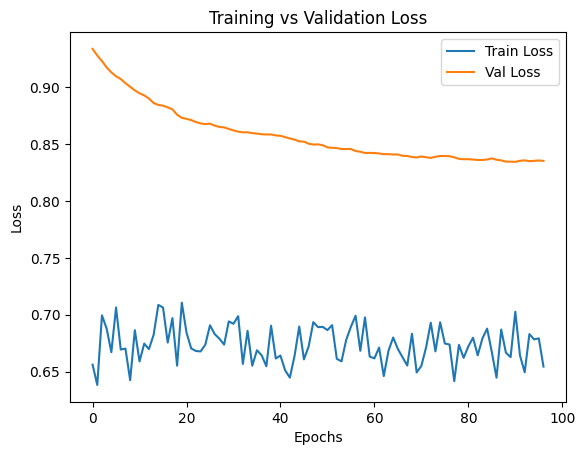

In [9]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [10]:
loss, acc, auc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

1/1 - 0s - 62ms/step - AUC: 0.4653 - accuracy: 0.7143 - loss: 0.8344
Restored model, accuracy: 71.43%


In [11]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply threshold to get binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)

print("CNN:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="macro", zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average="macro", zero_division=0))

print(classification_report(y_test, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
CNN:
Accuracy: 0.07142857142857142
Precision: 0.3481481481481481
Recall: 0.5555555555555555
F1 Score: 0.42777777777777776
              precision    recall  f1-score   support

        mint       0.44      0.67      0.53         6
        leak       0.60      1.00      0.75         3
       limit       0.00      0.00      0.00         9

   micro avg       0.50      0.39      0.44        18
   macro avg       0.35      0.56      0.43        18
weighted avg       0.25      0.39      0.30        18
 samples avg       0.43      0.26      0.32        18

